In [25]:
import oracledb
import cx_Oracle
from datetime import datetime, timedelta
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
try:
    cx_Oracle.init_oracle_client(lib_dir=r"F:\ruslan\dev\oracle\instantclient_19_9")
except:
    pass


In [3]:
conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
cursor_nwp = conn_nwp.cursor()

cursor_nwp.execute("""
/* SELECT to_char(DATAS, 'YYYY-MM-DD'), ADVANCE_TIME,  TEMP */
SELECT DATAS, ADVANCE_TIME,  TEMP
FROM NWP.GROUND_DATA
WHERE CITY_ID = 936 
      AND model_id = 4
      AND ADVANCE_TIME between 0 and 48
      AND datas >= '01-08-2022'
      /*AND datas between '01-08-2022' and '31-12-2022'*/
      AND to_char(datas, 'HH24') = '00'
ORDER BY datas, advance_time
""")
date = None
forecast_arr = []
f_row = [] 
for c in cursor_nwp:
    # Нова дата - создаем новую строку данных
    if date != c[0]:
        # Если дата пройдена, присоединить строку данных f_row к массиву forecast_arr
        if date:
            forecast_arr.append(f_row) 
        # Инициализируем следующую дату и строку данных
        date = c[0]       
        f_row = [None for _ in range(50)]
        f_row[0] = c[0] # Дату c[0] записать в позицию 0
    # В позицию списка, равную заблаговременности c[1] записать температуру c[2]
    f_row[c[1] + 1] = c[2]
# Присоединить последнюю строку данных f_row к массиву forecast_arr
forecast_arr.append(f_row)        
# print(*forecast_arr, sep='\n')
conn_nwp.close()

In [4]:
conn_gts = cx_Oracle.connect(user="cligts", password="belorgmc", dsn="192.168.211.173/clidb")
cursor_gts = conn_gts.cursor()

cursor_gts.execute(
"""
SELECT DATE_OBS, TEMPDB
FROM gts.synop
WHERE 
      date_obs >= '01-08-2022'
      /* date_obs between '01-08-2022' and '31-12-2022' */
      AND station_id = '26850'
""")

gts_rows = cursor_gts.fetchall()
# for c in gts_rows:
#     print(c)

conn_gts.close()

In [5]:
# Формирование y - значений фактической температуры, соответствующих каждой дате на 48 часов вперед
# Поиск каждой совпадающей строки по дате и сроку 00
start = 0
fact_arr = []
forecast_X = []
td48 = timedelta(hours=48)
for f in forecast_arr:
    date_nwp = f[0]
    # Прервать выполнение, если от даты прогноза до текущего момента 
    # прошло менее или ровно 48 часов, т.к. не будет соответствующих фактических данных
    if datetime.today() - date_nwp <= td48:
        print(datetime.today() - date_nwp)
        print(f'Прервано - для даты {date_nwp} не хватит фактических данных!')
        break
    # print('NWP Date:', date_nwp)
    # print('GTS start:', start)
    for i, g in enumerate(gts_rows[start:]):
        if g[0] == f[0]: # Строка найдена
            # print(f[0])
            start += i
            forecast_X.append(f)
            break
    # Инициализировать строку данных для фактической температуры 17 значений
    g_row = [None for _ in range(18)]
    g_row[0] = g[0]
    # print('GTS Date:', g[0])
    for j in range(17):
        gts_date = gts_rows[start + j][0]
        gts_temperature = gts_rows[start + j][1]
        td = gts_date - date_nwp
        # print('Time delta for g_row:', td, 'Temper;', gts_temperature)
        # В пределах 48 часов
        if td <= td48:
            td_hours = int(td.days * 24 + td.seconds / 3600)
            # print('td_hours', td_hours)
            cell = td_hours // 3
            # print('cell', cell)
            g_row[cell + 1] = gts_temperature
        else:
            # start += i #!!!!
            print('BREAK!!!')
            break
    fact_arr.append(g_row)
    # print(g_row)

# print(*forecast_arr, sep='\n')
# print('Fact:')
# print(*fact_arr, sep='\n')

fact_y = fact_arr


1 day, 16:57:21.152183
Прервано - для даты 2024-01-02 00:00:00 не хватит фактических данных!


In [6]:
# Проверка на пропущенные значения (None)
damaged_rows = set()

for i, (x, y) in enumerate(zip(forecast_X, fact_y)):
    if x[0] != y[0]:
        print(x[0], y[0])
    damage_x = False
    for xi in x: 
        if xi is None:
            damage_x = True
            break
    if damage_x:
        damaged_rows.add(i)
        print('x', x)
    
    damage_y = False
    for yi in y: 
        if yi is None:
            damage_y = True
            break
    if damage_y:
        damaged_rows.add(i)
        print('y', y)

damaged_rows = sorted(list(damaged_rows), reverse=True)
print(damaged_rows)

# Удаление строк с пропусками
for i in damaged_rows:
    forecast_X.pop(i)
    fact_y.pop(i)


x [datetime.datetime(2022, 11, 5, 0, 0), 4.638, 4.118, 3.396, 2.756, 1.855, 0.817, 0.668, 1.091, 2.043, 3.152, 4.045, 4.577, 4.541, 4.278, 3.244, 2.414, 1.979, 1.642, 1.631, 1.587, 1.535, 1.776, 2.175, 2.486, 2.702, 2.911, 3.105, 3.308, 3.55, 3.769, 4.043, 4.34, 4.66, 4.954, 5.217, 5.46, 5.622, 5.774, 5.864, 5.897, 5.978, 6.109, 6.303, 6.368, 6.331, 6.58, None, 6.754, 6.694]
x [datetime.datetime(2022, 11, 7, 0, 0), 4.293, 4.187, 4.182, 4.581, 4.85, 5.203, 5.301, 5.838, 6.525, 6.703, 6.846, 7.786, 8.512, None, 8.476, 8.345, 8.393, 8.356, 8.256, 8.161, 8.123, 7.983, 7.41, 6.643, 5.99, 5.361, 5.144, 5.378, 5.498, 5.401, 5.217, 5.913, 6.881, 7.712, 7.816, 7.75, 7.756, 7.926, 7.894, 7.805, 7.803, 7.862, 7.685, 7.696, 7.865, 7.862, 7.844, 7.939, 7.097]
x [datetime.datetime(2022, 12, 23, 0, 0), 1.255, 1.178, 1.157, 1.155, 1.09, 1.152, 1.127, 1.014, 0.988, None, 0.932, 0.925, 0.937, 0.932, 0.851, 1.016, 0.678, 0.629, 0.662, 0.736, 0.416, 0.092, 0.151, 0.228, 0.389, 0.466, 0.452, 0.462, 0.471, 

In [7]:
# Проверка на пропущенные значения (None)
damaged_rows = set()

for i, (x, y) in enumerate(zip(forecast_X, fact_y)):
    if x[0] != y[0]:
        print(x[0], y[0])
    damage_x = False
    for xi in x: 
        if xi is None:
            damage_x = True
            break
    if damage_x:
        damaged_rows.add(i)
        print('x', x)
    
    damage_y = False
    for yi in y: 
        if yi is None:
            damage_y = True
            break
    if damage_y:
        damaged_rows.add(i)
        print('y', y)

damaged_rows = sorted(list(damaged_rows), reverse=True)
print(damaged_rows)

[]


In [8]:


X = np.array([x[1:] for x in forecast_X])
y = np.array([y[1:] for y in fact_y])

print(X.shape)
print(y.shape)

(444, 49)
(444, 17)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True)
print(X_train)
model = KNeighborsRegressor(n_neighbors = 25)
# model = RidgeCV()
# model = ExtraTreesRegressor(n_estimators=150, random_state=0)
# model = RandomForestRegressor(n_estimators=150, random_state=0)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
r2 = model.score(X_test, y_test)
r2

[[ 0.196 -0.103 -0.327 ...  0.533  0.19   0.072]
 [-8.237 -8.03  -8.791 ... -0.477 -0.651 -0.867]
 [ 8.109  7.596  7.954 ... 12.376 12.089 11.978]
 ...
 [-2.397 -2.27  -2.183 ...  0.285  0.251  0.16 ]
 [ 5.688  5.664  5.643 ...  7.98   7.68   7.367]
 [ 5.348  4.021  3.043 ...  7.176  7.139  7.298]]


0.9141338542369875

[[ -0.5    -3.296  -0.072]
 [  0.2    -3.056   0.15 ]
 [  0.5    -2.98    0.515]
 [  0.6    -2.704   1.05 ]
 [  0.3    -2.684   0.875]
 [ -0.7    -3.268   0.073]
 [ -1.8    -3.768  -1.735]
 [ -3.1    -4.54   -4.601]
 [ -5.5    -4.776  -7.587]
 [ -7.5    -5.136 -10.646]
 [-10.7    -5.624 -11.858]
 [-13.     -5.192 -11.796]
 [-12.9    -4.796 -10.958]
 [-15.1    -5.416 -11.549]
 [-16.7    -6.224 -11.872]
 [-17.1    -6.42  -11.634]
 [-18.6    -6.52  -10.949]]
[ -0.5   0.2   0.5   0.6   0.3  -0.7  -1.8  -3.1  -5.5  -7.5 -10.7 -13.
 -12.9 -15.1 -16.7 -17.1 -18.6]
[-3.296 -3.056 -2.98  -2.704 -2.684 -3.268 -3.768 -4.54  -4.776 -5.136
 -5.624 -5.192 -4.796 -5.416 -6.224 -6.42  -6.52 ]
[ -0.072   0.15    0.515   1.05    0.875   0.073  -1.735  -4.601  -7.587
 -10.646 -11.858 -11.796 -10.958 -11.549 -11.872 -11.634 -10.949]


<Axes: >

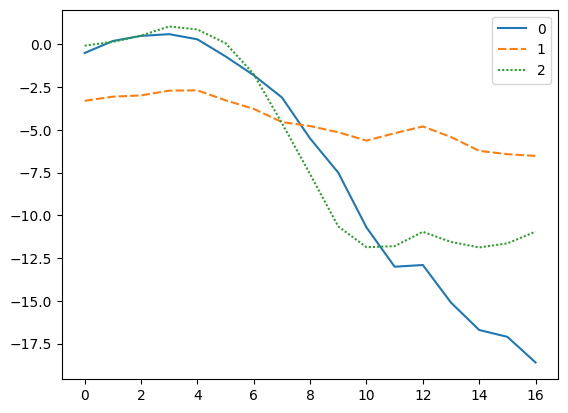

In [24]:
# test_data = np.vstack((y_test[20], predicted[20])).T
test_data = np.vstack((y_test[-1], predicted[-1], X_test[-1][::3])).T
# test_data = np.vstack((y_test[-1], y_test[-2], X_test[-1][::3])).T
print(test_data)
print(y_test[-1])
print(predicted[-1])
print(X_test[-1][::3])

sns.lineplot(data=test_data)

In [28]:
arr = np.array(
   [[0], 
    [2],
    [1], 
    [4], 
    [-2], 
    [1], 
    [-4]]
)

spt = SplineTransformer(n_knots=13)
arr2 = spt.fit_transform(arr)
print(arr2)

[[0.         0.         0.         0.         0.         0.
  0.16666667 0.66666667 0.16666667 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.16666667 0.66666667 0.16666667
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.02083333 0.47916667 0.47916667 0.02083333 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.16666667 0.66666667 0.16666667]
 [0.         0.         0.         0.16666667 0.66666667 0.16666667
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.02083333 0.47916667 0.47916667 0.02083333 0.
  0.         0.         0.        ]
 [0.16666667 0.66666667 0.16666667 0.         0.